# Impact of bit collisions on learning performance: MoleculeACE data sets



# Algorithms and fingerprints

The fingerprints examined here:
1. MFP2: Morgan fingerprint, radius = 2
2. MFP3: Morgan fingerprint, radius = 3
3. RDK5: RDKit fingerprint, max path length = 5
4. HashAP: atom pairs, using [count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)
5. HashTT: topological torsions, [using count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)

I considered 1K, 8K, and 16K versions of each fingerprint type.

The learning algorithms:
1. LR: logistic regression, sklearn implementation
2. LMNB: Laplacian Naive Bayes, [NIBR implementation](https://github.com/rdkit/lmnb)
3. RF: random forest, sklearn implementation
4. BRF: balanced random forest, [imbalanced-learn implementation](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)
5. XGB: extreme gradient boosting, [XGBoost implementation](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

I've dropped the sklearn Naive Bayes classifier I looked at in the [first post in the series](https://greglandrum.github.io/rdkit-blog/posts/2022-12-25-colliding-bits-ii-revisited.html) since there were problems with that and I haven't gone back to figure out what's going on yet.


# Results summary

Here's a summary of the comparison of the 1K and 16K fingerprints using AUC as a metric (there's an table at the bottom with other metrics).
The `result` column indicates whether the AUC value for the short fingerprint is usually less than (`lt`), the same as `same`, or greater than (`gt`) the AUC value for the long fingerprint. The `P` column provides the P value for the difference (assessed using scipy's [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html). The threshold for significance used was 0.01. The `delt` column has the median difference between the short-fingerprint AUC and long-fingerprint AUC. The `pct_delt` column indicates the median percentage change in AUC relative to the short-fingerprint AUC.





In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import intake
import rdkit
print(rdkit.__version__)
import time
print(time.asctime())
%pylab inline
plt.style.use('tableau-colorblind10')


2022.09.1
Tue Jan 17 13:19:12 2023
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
datasets = intake.open_catalog('/localhome/glandrum/Datasets/MoleculeACE/MoleculeACE/Data/MoleculeACE.yaml')

In [3]:
list(datasets.keys())

['CHEMBL1871_Ki',
 'CHEMBL218_EC50',
 'CHEMBL244_Ki',
 'CHEMBL236_Ki',
 'CHEMBL234_Ki',
 'CHEMBL219_Ki',
 'CHEMBL238_Ki',
 'CHEMBL4203_Ki',
 'CHEMBL2047_EC50',
 'CHEMBL4616_EC50',
 'CHEMBL2034_Ki',
 'CHEMBL262_Ki',
 'CHEMBL231_Ki',
 'CHEMBL264_Ki',
 'CHEMBL2835_Ki',
 'CHEMBL2971_Ki',
 'CHEMBL237_EC50',
 'CHEMBL237_Ki',
 'CHEMBL4792_Ki',
 'CHEMBL239_EC50',
 'CHEMBL3979_EC50',
 'CHEMBL235_EC50',
 'CHEMBL4005_Ki',
 'CHEMBL2147_Ki',
 'CHEMBL214_Ki',
 'CHEMBL228_Ki',
 'CHEMBL287_Ki',
 'CHEMBL204_Ki',
 'CHEMBL1862_Ki',
 'CHEMBL233_Ki']

In [4]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from bayes.LaplacianNB import LaplacianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


import random
import pickle
import gzip
import os

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score
)
import ghostml

metrics = {
    'precision_score':precision_score,
    'recall_score':recall_score,
    'accuracy_score':accuracy_score,
    'balanced_accuracy_score':balanced_accuracy_score,
    'f1_score':f1_score,
    'cohen_kappa_score':cohen_kappa_score,
}

def run_target(tgt,catalog,fpnm,fpgen,cls, act_frac=0.5, sparse=False):
    fn = f'results/MoleculeACE_{tgt}.{fpnm}.pkl.gz'
    df = catalog[tgt].read()
    if os.path.exists(fn):
        print('   Reading fingerprints')
        with gzip.open(fn,'rb') as inf:
            fps = pickle.load(inf)
    else:
        print('   Generating fingerprints')
        fps = np.array([fpgen.GetFingerprintAsNumPy(x) for x in df.mol if x is not None])
        with gzip.open(fn,'wb+') as outf:
            pickle.dump(fps,outf)

            
    thresh = np.quantile(df['exp_mean [nM]'],act_frac)
    act_labels = [1 if x <= thresh else 0 for x in df['exp_mean [nM]']]
    
    split = np.array(df['split'].to_list())
    trainIndices = [i for i,x in enumerate(split) if x=='train']
    testIndices = [i for i,x in enumerate(split) if x=='test']

    res = {}

    
    print('   Building model')

    X_T = np.take(fps,trainIndices,axis=0)
    X_V = np.take(fps,testIndices,axis=0)
    y_T = np.take(act_labels,trainIndices)
    y_V = np.take(act_labels,testIndices)

    # clear up memory
    fps = None
    
    if sparse:
        X_T = [set(np.where(v)[0]) for v in X_T]
        X_V = [set(np.where(v)[0]) for v in X_V]
            
    
    cls.fit(X_T,y_T)
    
    # training set performance
    pred_probs = [x[1] for x in cls.predict_proba(X_T)]
    pred_order = list(np.argsort(pred_probs))
    pred_order.reverse()
    pred_probs = np.take(pred_probs,pred_order)
    true_labels = np.take(y_T,pred_order)
    
    
    pred_labels = [1 if x>=0.5 else 0 for x in pred_probs]

    for metric in metrics:
        res['train_'+metric] = metrics[metric](true_labels,pred_labels)
    res['train_roc_auc_score'] = roc_auc_score(true_labels,pred_probs)
    res['train_average_precision_score'] = average_precision_score(true_labels,pred_probs)


    # test set performance
    pred_probs = [x[1] for x in cls.predict_proba(X_V)]
    pred_order = list(np.argsort(pred_probs))
    pred_order.reverse()
    pred_probs = np.take(pred_probs,pred_order)
    true_labels = np.take(y_V,pred_order)
    
    
    pred_labels = [1 if x>=0.5 else 0 for x in pred_probs]

    for metric in metrics:
        res[metric] = metrics[metric](true_labels,pred_labels)

    train_probs = [x[1] for x in cls.predict_proba(X_T)]    
    thresh = ghostml.optimize_threshold_from_predictions(y_T,train_probs,thresholds=np.arange(0.05,0.5,0.05))
    res['ghost_thresh'] = thresh
    pred_labels = [1 if x>=thresh else 0 for x in pred_probs]
    for metric in metrics:
        res[metric+'_ghost'] = metrics[metric](true_labels,pred_labels)

    res['roc_auc_score'] = roc_auc_score(true_labels,pred_probs)
    res['average_precision_score'] = average_precision_score(true_labels,pred_probs)
    print('Done!')
    return res
    

In [5]:
from collections import defaultdict
accum = defaultdict(dict)

We're using the training/test splits from the original paper here

In [6]:
gens = [('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
          
         ]


In [7]:
from collections import defaultdict

#accum = defaultdict(dict)

for nm,fpg in gens:
    print(f'----------- {nm}')
    for fpcnt in (128,256,512,1024,8192,16384):   
        print(f'    -------------- {fpcnt} Bits')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for di,tgt in enumerate(datasets):
            if fpkey in accum['lr'] and tgt in accum['lr'][fpkey]:
                continue
            print(f'  Running dataset {tgt} ({di+1}/{len(datasets)})')

            print('  XGB')
            cls = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=6)
            if fpkey not in accum['xgb']:
                accum['xgb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
            res = run_target(tgt,datasets,fpkey,fpgen,cls)
            if res is None:
                # not enough actives, so we skip this
                continue
            accum['xgb'][fpkey][tgt] = res

            print('  lmnb')
            cls =  LaplacianNB(alpha=1.0, fit_prior=True)
            if fpkey not in accum['lmnb']:
                accum['lmnb'][fpkey] = defaultdict(dict)
            accum['lmnb'][fpkey][tgt] = run_target(tgt,datasets,fpkey,fpgen,cls,sparse=True)

            
            print('  BRF')
            cls = BalancedRandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['brf']:
                accum['brf'][fpkey] = defaultdict(dict)
            accum['brf'][fpkey][tgt] = run_target(tgt,datasets,fpkey,fpgen,cls)
            
            print('  RF')
            cls = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['rf']:
                accum['rf'][fpkey] = defaultdict(dict)
            accum['rf'][fpkey][tgt] = run_target(tgt,datasets,fpkey,fpgen,cls)

            print('  LR')
            cls = LogisticRegression(max_iter=1000)
            if fpkey not in accum['lr']:
                accum['lr'][fpkey] = defaultdict(dict)
            accum['lr'][fpkey][tgt] = run_target(tgt,datasets,fpkey,fpgen,cls)

            with open('results/MoleculeACE.pkl','wb+') as outf:
                pickle.dump(accum,outf)


----------- mfp2
    -------------- 128 Bits
  Running dataset CHEMBL1871_Ki (1/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL218_EC50 (2/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL244_Ki (3/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL236_Ki 

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL204_Ki (28/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL1862_Ki (29/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL233_Ki (30/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading

Done!
  Running dataset CHEMBL2147_Ki (24/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL214_Ki (25/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL228_Ki (26/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL287_Ki (27/30)
  XGB
   Reading fingerprints


Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL3979_EC50 (21/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL235_EC50 (22/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4005_Ki (23/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Re

Done!
  Running dataset CHEMBL237_EC50 (17/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_Ki (18/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4792_Ki (19/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL239_EC50 (20/30)
  XGB
   Reading fingerpri

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL264_Ki (14/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2835_Ki (15/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2971_Ki (16/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Readin

Done!
  Running dataset CHEMBL4616_EC50 (10/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2034_Ki (11/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL262_Ki (12/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL231_Ki (13/30)
  XGB
   Reading fingerprin

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL238_Ki (7/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4203_Ki (8/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2047_EC50 (9/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading

Done!
  Running dataset CHEMBL244_Ki (3/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL236_Ki (4/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL234_Ki (5/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL219_Ki (6/30)
  XGB
   Reading fingerprints
   Bu

Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL233_Ki (30/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
    -------------- 512 Bits
  Running dataset CHEMBL1871_Ki (1/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL218_EC50 (2/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building 

   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL287_Ki (27/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL204_Ki (28/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL1862_Ki (29/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerpri

Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4005_Ki (23/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2147_Ki (24/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL214_Ki (25/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading

   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL239_EC50 (20/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL3979_EC50 (21/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL235_EC50 (22/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fin

Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2971_Ki (16/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_EC50 (17/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_Ki (18/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Readin

   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL231_Ki (13/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL264_Ki (14/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2835_Ki (15/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerpri

Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2047_EC50 (9/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4616_EC50 (10/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2034_Ki (11/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Rea

   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL219_Ki (6/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL238_Ki (7/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4203_Ki (8/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints

Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL218_EC50 (2/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL244_Ki (3/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL236_Ki (4/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fi

Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL1862_Ki (29/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL233_Ki (30/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
    -------------- 8192 Bits
  Running dataset CHEMBL1871_Ki (1/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Buildi

Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL214_Ki (25/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL228_Ki (26/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL287_Ki (27/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset

Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL235_EC50 (22/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4005_Ki (23/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2147_Ki (24/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Re

Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_Ki (18/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4792_Ki (19/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL239_EC50 (20/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running data

Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2835_Ki (15/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2971_Ki (16/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_EC50 (17/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Re

Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2034_Ki (11/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL262_Ki (12/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL231_Ki (13/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running datase

Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4203_Ki (8/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2047_EC50 (9/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4616_EC50 (10/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   R

Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL236_Ki (4/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL234_Ki (5/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL219_Ki (6/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CH

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
    -------------- 16384 Bits
  Running dataset CHEMBL1871_Ki (1/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL218_EC50 (2/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL244_Ki (3/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Buildin

Done!
  Running dataset CHEMBL287_Ki (27/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL204_Ki (28/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL1862_Ki (29/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL233_Ki (30/30)
  XGB
   Reading fingerprints


Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2147_Ki (24/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL214_Ki (25/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL228_Ki (26/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading

Done!
  Running dataset CHEMBL239_EC50 (20/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL3979_EC50 (21/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL235_EC50 (22/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4005_Ki (23/30)
  XGB
   Reading finger

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_EC50 (17/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL237_Ki (18/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4792_Ki (19/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Readi

Done!
  Running dataset CHEMBL231_Ki (13/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL264_Ki (14/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2835_Ki (15/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2971_Ki (16/30)
  XGB
   Reading fingerprints

Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4616_EC50 (10/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2034_Ki (11/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL262_Ki (12/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Read

Done!
  Running dataset CHEMBL219_Ki (6/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL238_Ki (7/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL4203_Ki (8/30)
  XGB
   Reading fingerprints
   Building model
Done!
  lmnb
   Reading fingerprints
   Building model
Done!
  BRF
   Reading fingerprints
   Building model
Done!
  RF
   Reading fingerprints
   Building model
Done!
  LR
   Reading fingerprints
   Building model
Done!
  Running dataset CHEMBL2047_EC50 (9/30)
  XGB
   Reading fingerprints
 

In [8]:
import pickle
with open('results/MoleculeACE.pkl','rb') as inf:
    accum = pickle.load(inf)

EOFError: Ran out of input

# Results

In [8]:
_markers = ['o','v','+','x','^','<']
def do_plots(alg,fp,accum,val1='roc_auc_score',val2='average_precision_score',
            autoscale=False,bcounts=(16384,8192,256,128)):
    figsize(12,6)
    subplot(1,2,1)
    for i,bcnt in enumerate(bcounts):
        scatter([x[val1] for x in accum[alg][f'{fp}-1024'].values()],[x[val1] for x in accum[alg][f'{fp}-{bcnt}'].values()],
                label=str(bcnt),marker=_markers[i%len(_markers)])

    if not autoscale:
        plot((0.6,1),(0.6,1),'k');
    else:
        xmin,xmax = xlim()
        ymin,ymax = ylim()
        minv = min(xmin,ymin)
        maxv = min(xmax,ymax)
        plot((minv,maxv),(minv,maxv),'k');
        
    xlabel('1024 bits');
    title(f'{alg} {fp} {val1}')
    legend();

    subplot(1,2,2)
    for i,bcnt in enumerate(bcounts):
        scatter([x[val2] for x in accum[alg][f'{fp}-1024'].values()],[x[val2] for x in accum[alg][f'{fp}-{bcnt}'].values()],
                label=str(bcnt),marker=_markers[i%len(_markers)])

    if not autoscale:
        plot((0.6,1),(.6,1),'k');
    else:
        xmin,xmax = xlim()
        ymin,ymax = ylim()
        minv = min(xmin,ymin)
        maxv = min(xmax,ymax)
        plot((minv,maxv),(minv,maxv),'k');
    xlabel('1024 bits');
    title(f'{alg} {fp} {val2}')
    legend();


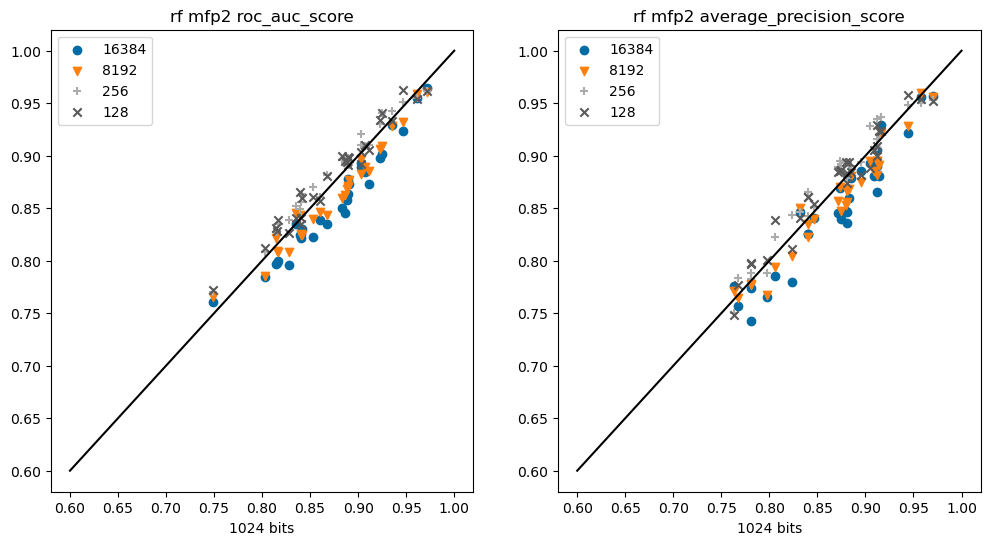

In [9]:
do_plots('rf','mfp2',accum)

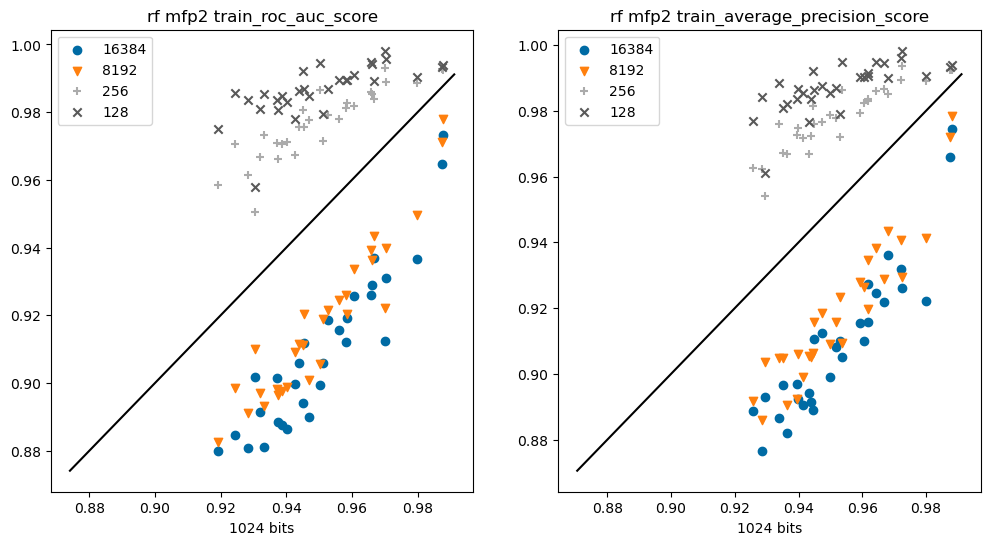

In [13]:
do_plots('rf','mfp2',accum,val1='train_roc_auc_score',val2='train_average_precision_score',autoscale=True)

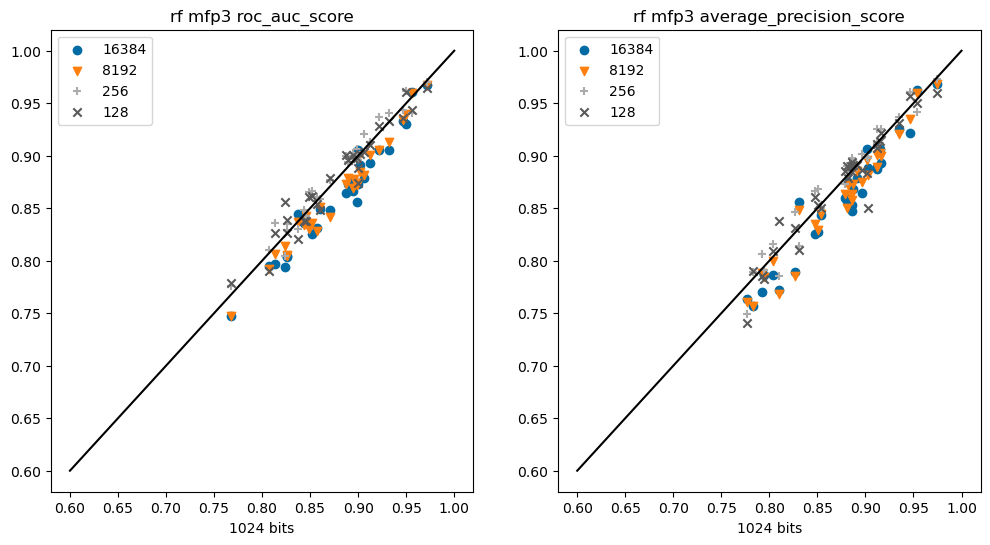

In [73]:
do_plots('rf','mfp3',accum)

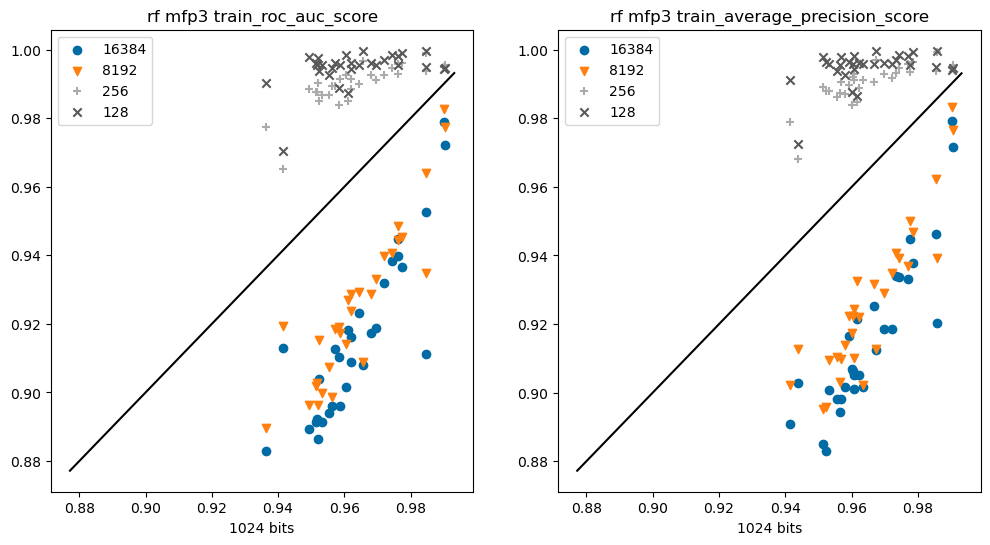

In [14]:
do_plots('rf','mfp3',accum,val1='train_roc_auc_score',val2='train_average_precision_score',autoscale=True)

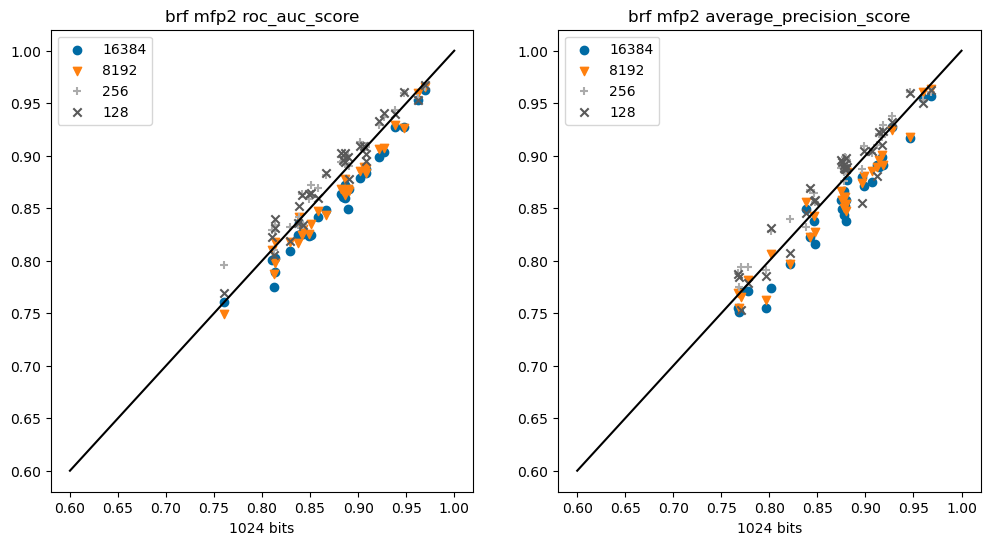

In [66]:
do_plots('brf','mfp2',accum)

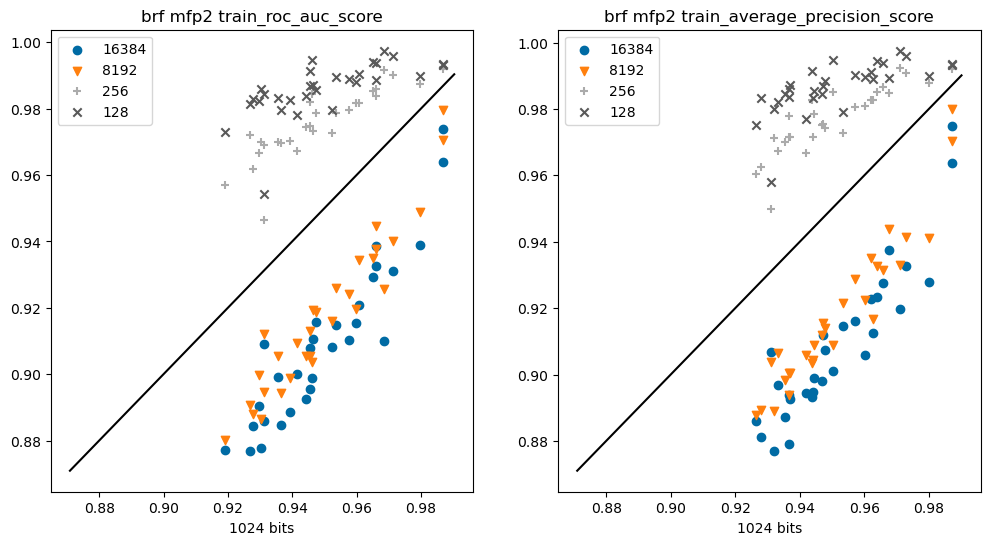

In [15]:
do_plots('brf','mfp2',accum,val1='train_roc_auc_score',val2='train_average_precision_score',autoscale=True)

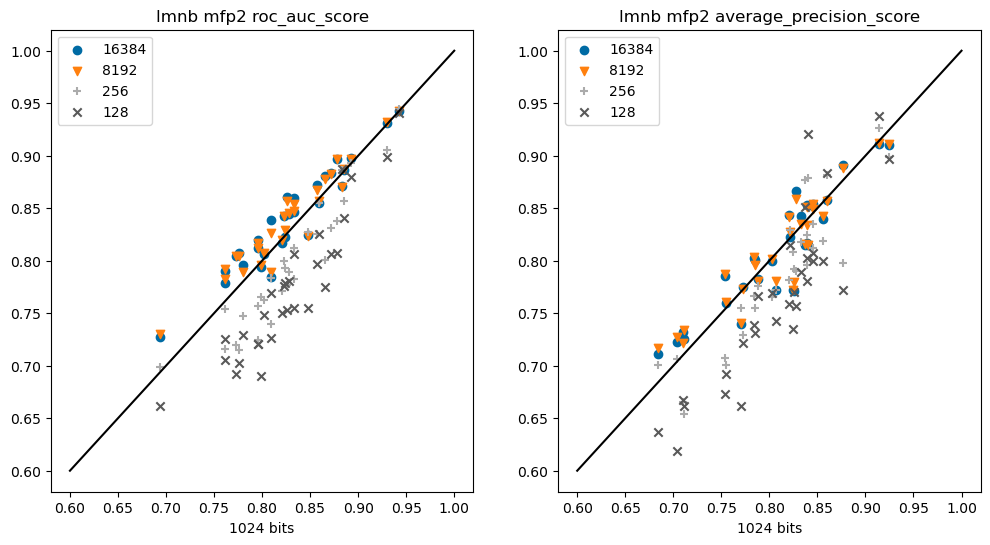

In [67]:
do_plots('lmnb','mfp2',accum)

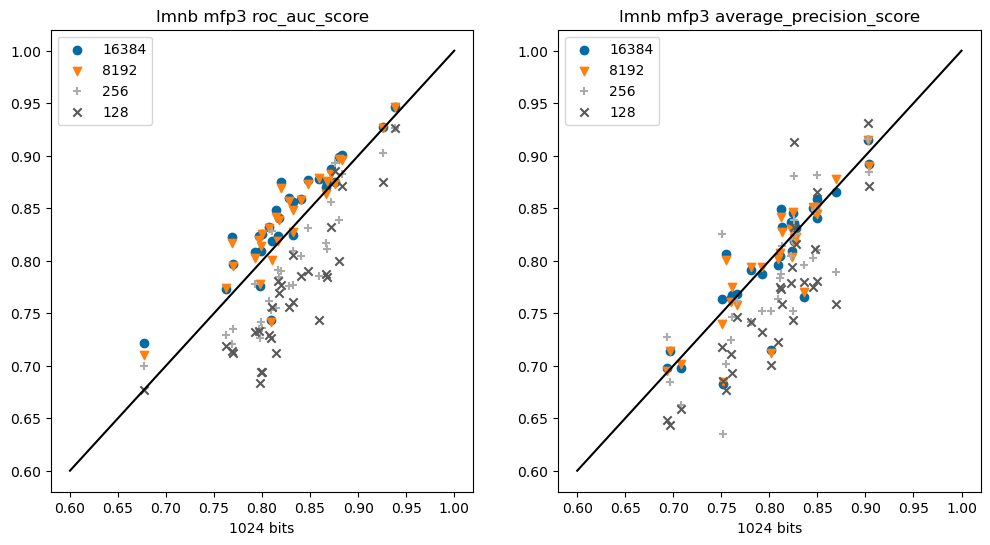

In [68]:
do_plots('lmnb','mfp3',accum)

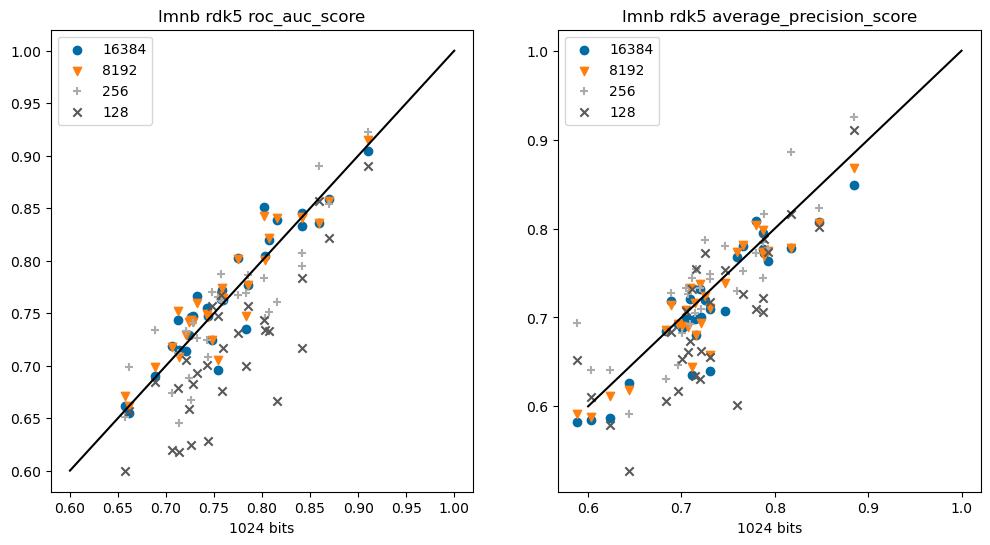

In [69]:
do_plots('lmnb','rdk5',accum)

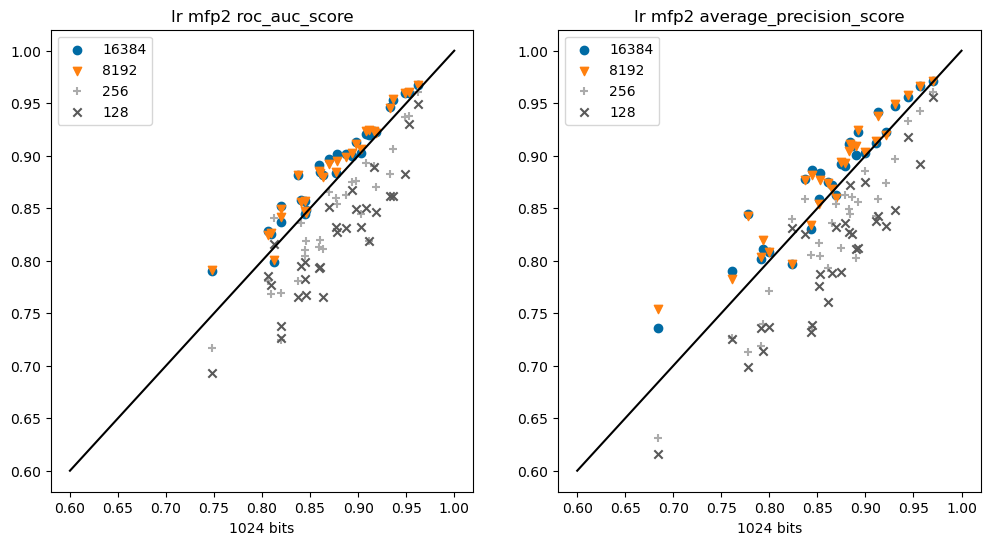

In [70]:
do_plots('lr','mfp2',accum)

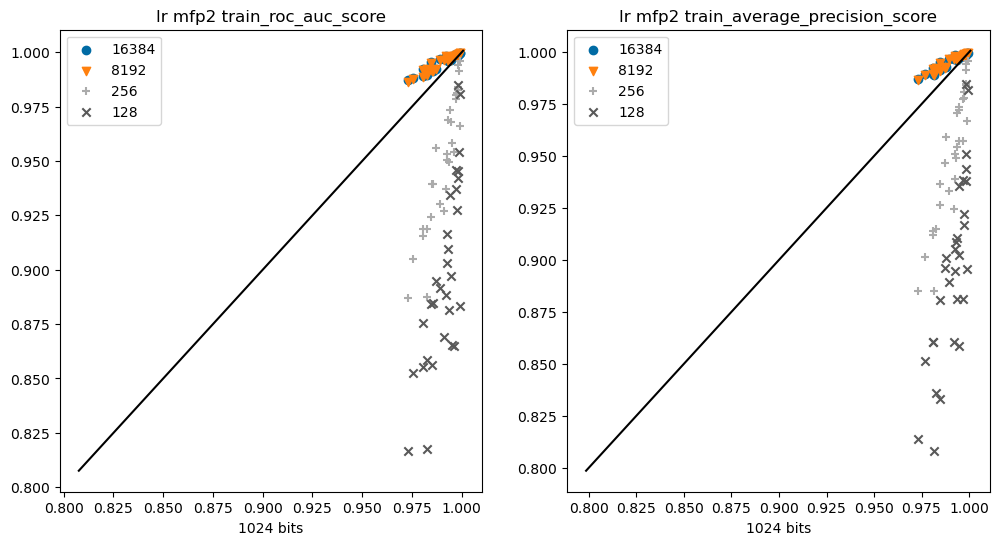

In [16]:
do_plots('lr','mfp2',accum,val1='train_roc_auc_score',val2='train_average_precision_score',autoscale=True)

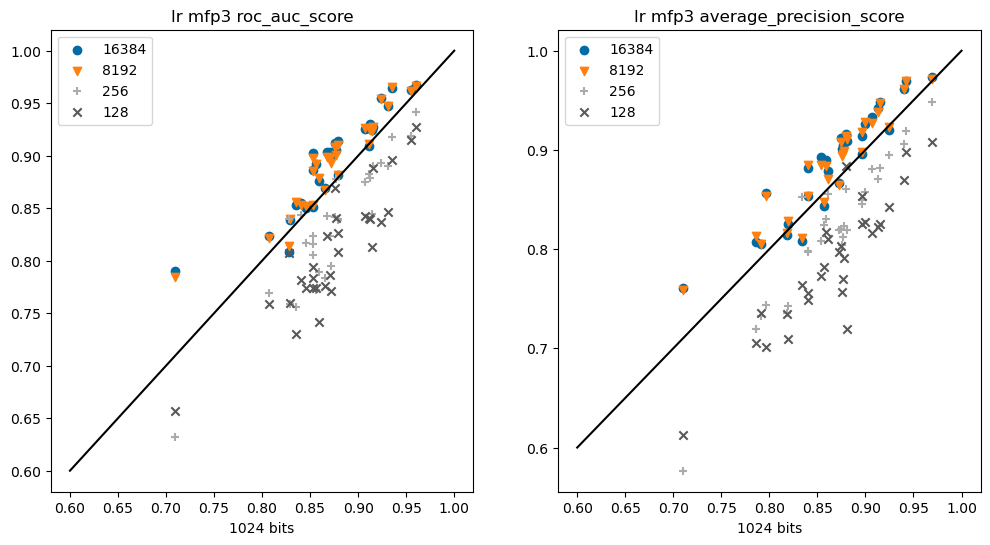

In [71]:
do_plots('lr','mfp3',accum)

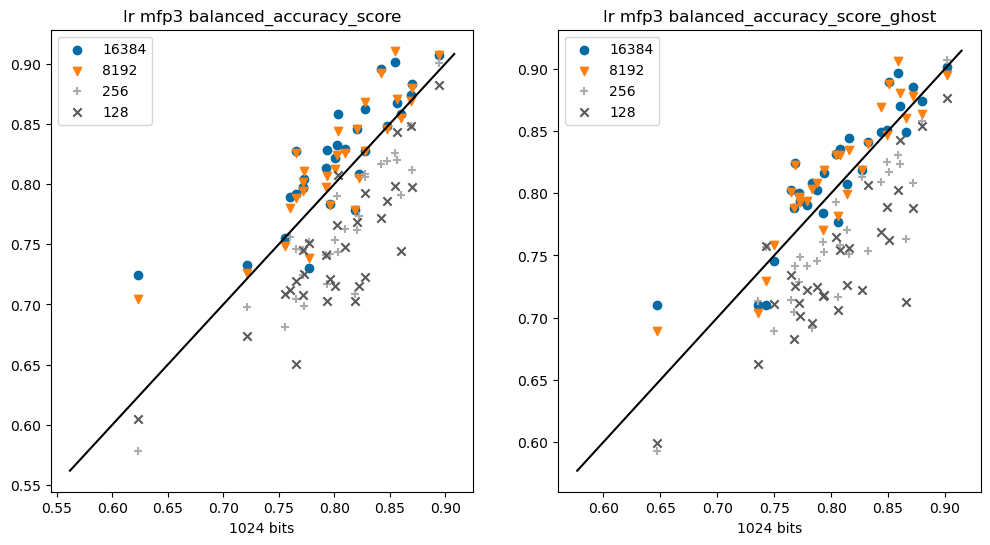

In [72]:
do_plots('lr','mfp3',accum,
         val1='balanced_accuracy_score',val2='balanced_accuracy_score_ghost',
        autoscale=True)

# Where does FP size really make a difference?

In [51]:
from scipy import stats

In [52]:
def do_significance(alg,fp,size1=1024,size2=16384,
                    tableOutput=False,showHeader=False,pthresh=0.001,accum=accum,metrics=metrics):
  
    v1s = defaultdict(list)
    v2s = defaultdict(list)
    delts = defaultdict(list)
    pct_delts = defaultdict(list)

    if tableOutput and showHeader:
        row = ('alg','fp','metric','result','P','delt','pct_delt')
        divider = ['-'*len(k) for k in row]
        print('| '+' | '.join(row)+' |')
        print('| '+' | '.join(divider)+' |')
        
        
    res1 = accum[alg][f'{fp}-{size1}']
    res2 = accum[alg][f'{fp}-{size2}']
    
    for d1,d2 in zip(res1.values(),res2.values()):
        for metric in metrics:
            v1 = d1[metric]
            v2 = d2[metric]
            v1s[metric].append(v1)
            v2s[metric].append(v2)
            delt = v1-v2
            delts[metric].append(delt)
            pct_delts[metric].append(delt/v1)
    for metric in metrics:
        w2s = stats.wilcoxon(v1s[metric],v2s[metric],alternative='two-sided').pvalue
        wlt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='less').pvalue
        wgt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='greater').pvalue
        result = 'same'
        which = w2s
        if wlt<pthresh or wgt<pthresh:
            if wlt < pthresh:
                result = 'lt'
                which = wlt
            elif wgt < pthresh:
                result = 'gt'
                which = wgt
        elif w2s<pthresh:
            result='diff'
        row = (alg,fp,metric,result,f'{which:.3g}',f'{np.median(delts[metric]):.2g}',f'{np.median(pct_delts[metric]):.3g}')
        if not tableOutput:
            print(' '.join(row))
        else:
            print('| '+' | '.join(row)+' |')

## Compare 1024 to 16K

In [53]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lr','lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | lt | 2.36e-07 | -0.014 | -0.0157 |
| lr | mfp3 | roc_auc_score | lt | 4.16e-07 | -0.018 | -0.0203 |
| lr | rdk5 | roc_auc_score | same | 0.00814 | -0.009 | -0.01 |
| lr | hashap | roc_auc_score | lt | 9.31e-09 | -0.036 | -0.0422 |
| lr | hashtt | roc_auc_score | lt | 1.77e-08 | -0.013 | -0.0146 |
| lmnb | mfp2 | roc_auc_score | lt | 0.000476 | -0.015 | -0.0179 |
| lmnb | mfp3 | roc_auc_score | lt | 4.43e-05 | -0.017 | -0.0201 |
| lmnb | rdk5 | roc_auc_score | same | 0.262 | -0.0038 | -0.00486 |
| lmnb | hashap | roc_auc_score | same | 0.0345 | -0.014 | -0.0174 |
| lmnb | hashtt | roc_auc_score | lt | 8.49e-05 | -0.012 | -0.0155 |
| rf | mfp2 | roc_auc_score | gt | 2.79e-09 | 0.022 | 0.0245 |
| rf | mfp3 | roc_auc_score | gt | 3.07e-08 | 0.019 | 0.0206 |
| rf | rdk5 | roc_auc_score | gt | 6.09e-06 | 0.01 | 0.0114 |
| rf | hashap | roc_a

### roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | lt | 2.36e-07 | -0.014 | -0.0157 |
| lr | mfp3 | roc_auc_score | lt | 4.16e-07 | -0.018 | -0.0203 |
| lr | rdk5 | roc_auc_score | same | 0.00814 | -0.009 | -0.01 |
| lr | hashap | roc_auc_score | lt | 9.31e-09 | -0.036 | -0.0422 |
| lr | hashtt | roc_auc_score | lt | 1.77e-08 | -0.013 | -0.0146 |
| lmnb | mfp2 | roc_auc_score | lt | 0.000476 | -0.015 | -0.0179 |
| lmnb | mfp3 | roc_auc_score | lt | 4.43e-05 | -0.017 | -0.0201 |
| lmnb | rdk5 | roc_auc_score | same | 0.262 | -0.0038 | -0.00486 |
| lmnb | hashap | roc_auc_score | same | 0.0345 | -0.014 | -0.0174 |
| lmnb | hashtt | roc_auc_score | lt | 8.49e-05 | -0.012 | -0.0155 |
| rf | mfp2 | roc_auc_score | gt | 2.79e-09 | 0.022 | 0.0245 |
| rf | mfp3 | roc_auc_score | gt | 3.07e-08 | 0.019 | 0.0206 |
| rf | rdk5 | roc_auc_score | gt | 6.09e-06 | 0.01 | 0.0114 |
| rf | hashap | roc_auc_score | gt | 0.000209 | 0.0079 | 0.00876 |
| rf | hashtt | roc_auc_score | gt | 1.86e-09 | 0.023 | 0.0259 |
| brf | mfp2 | roc_auc_score | gt | 9.31e-10 | 0.02 | 0.0225 |
| brf | mfp3 | roc_auc_score | gt | 1.3e-08 | 0.021 | 0.0243 |
| brf | rdk5 | roc_auc_score | gt | 6.52e-08 | 0.01 | 0.012 |
| brf | hashap | roc_auc_score | gt | 7.99e-06 | 0.0062 | 0.00719 |
| brf | hashtt | roc_auc_score | gt | 9.31e-10 | 0.024 | 0.027 |
| xgb | mfp2 | roc_auc_score | same | 0.191 | -0.0045 | -0.00491 |
| xgb | mfp3 | roc_auc_score | same | 0.031 | -0.0036 | -0.00392 |
| xgb | rdk5 | roc_auc_score | same | 0.0497 | -0.0029 | -0.00324 |
| xgb | hashap | roc_auc_score | same | 0.0106 | -0.0035 | -0.0039 |
| xgb | hashtt | roc_auc_score | same | 0.349 | -0.00018 | -0.000193 |



### average_precision_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | average_precision_score | lt | 9.12e-06 | -0.013 | -0.0147 |
| lr | mfp3 | average_precision_score | lt | 4e-06 | -0.026 | -0.0291 |
| lr | rdk5 | average_precision_score | same | 0.0919 | -0.008 | -0.00948 |
| lr | hashap | average_precision_score | lt | 2.36e-07 | -0.033 | -0.0378 |
| lr | hashtt | average_precision_score | lt | 0.000476 | -0.015 | -0.0167 |
| lmnb | mfp2 | average_precision_score | same | 0.808 | -0.0038 | -0.005 |
| lmnb | mfp3 | average_precision_score | same | 0.543 | -0.0036 | -0.0045 |
| lmnb | rdk5 | average_precision_score | same | 0.00299 | 0.014 | 0.0188 |
| lmnb | hashap | average_precision_score | same | 0.309 | 0.00011 | 0.000155 |
| lmnb | hashtt | average_precision_score | same | 0.808 | 0.0063 | 0.00768 |
| rf | mfp2 | average_precision_score | gt | 4.66e-09 | 0.022 | 0.0238 |
| rf | mfp3 | average_precision_score | gt | 1.38e-06 | 0.02 | 0.0229 |
| rf | rdk5 | average_precision_score | gt | 0.000277 | 0.0093 | 0.0107 |
| rf | hashap | average_precision_score | same | 0.00299 | 0.0089 | 0.0098 |
| rf | hashtt | average_precision_score | gt | 1.77e-08 | 0.023 | 0.0255 |
| brf | mfp2 | average_precision_score | gt | 2.33e-08 | 0.02 | 0.0231 |
| brf | mfp3 | average_precision_score | gt | 3.46e-07 | 0.025 | 0.0282 |
| brf | rdk5 | average_precision_score | gt | 1.73e-05 | 0.011 | 0.0128 |
| brf | hashap | average_precision_score | same | 0.0164 | 0.007 | 0.00763 |
| brf | hashtt | average_precision_score | gt | 1.3e-08 | 0.021 | 0.0241 |
| xgb | mfp2 | average_precision_score | same | 0.164 | -0.005 | -0.00539 |
| xgb | mfp3 | average_precision_score | same | 0.289 | -0.0053 | -0.00601 |
| xgb | rdk5 | average_precision_score | same | 0.824 | 0.0004 | 0.000476 |
| xgb | hashap | average_precision_score | same | 0.171 | -0.0045 | -0.00504 |
| xgb | hashtt | average_precision_score | same | 0.477 | -0.0016 | -0.0019 |

## Compare 1024 to 128

In [54]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lr','lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,size2=128,
                            tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | gt | 1.86e-09 | 0.057 | 0.0663 |
| lr | mfp3 | roc_auc_score | gt | 9.31e-10 | 0.069 | 0.0786 |
| lr | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.092 | 0.11 |
| lr | hashap | roc_auc_score | gt | 9.31e-10 | 0.13 | 0.159 |
| lr | hashtt | roc_auc_score | gt | 2.79e-09 | 0.06 | 0.0726 |
| lmnb | mfp2 | roc_auc_score | gt | 2.79e-09 | 0.055 | 0.0689 |
| lmnb | mfp3 | roc_auc_score | gt | 2.79e-09 | 0.058 | 0.0733 |
| lmnb | rdk5 | roc_auc_score | gt | 5.12e-08 | 0.047 | 0.0594 |
| lmnb | hashap | roc_auc_score | gt | 2.79e-09 | 0.12 | 0.156 |
| lmnb | hashtt | roc_auc_score | gt | 1.93e-07 | 0.047 | 0.0599 |
| rf | mfp2 | roc_auc_score | lt | 0.00023 | -0.01 | -0.0127 |
| rf | mfp3 | roc_auc_score | same | 0.935 | -2.5e-05 | -1.87e-05 |
| rf | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.071 | 0.0811 |
| rf | hashap | roc_auc_score | gt | 9.31e

And now render that

### roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | gt | 1.86e-09 | 0.057 | 0.0663 |
| lr | mfp3 | roc_auc_score | gt | 9.31e-10 | 0.069 | 0.0786 |
| lr | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.092 | 0.11 |
| lr | hashap | roc_auc_score | gt | 9.31e-10 | 0.13 | 0.159 |
| lr | hashtt | roc_auc_score | gt | 2.79e-09 | 0.06 | 0.0726 |
| lmnb | mfp2 | roc_auc_score | gt | 2.79e-09 | 0.055 | 0.0689 |
| lmnb | mfp3 | roc_auc_score | gt | 2.79e-09 | 0.058 | 0.0733 |
| lmnb | rdk5 | roc_auc_score | gt | 5.12e-08 | 0.047 | 0.0594 |
| lmnb | hashap | roc_auc_score | gt | 2.79e-09 | 0.12 | 0.156 |
| lmnb | hashtt | roc_auc_score | gt | 1.93e-07 | 0.047 | 0.0599 |
| rf | mfp2 | roc_auc_score | lt | 0.00023 | -0.01 | -0.0127 |
| rf | mfp3 | roc_auc_score | same | 0.935 | -2.5e-05 | -1.87e-05 |
| rf | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.071 | 0.0811 |
| rf | hashap | roc_auc_score | gt | 9.31e-10 | 0.11 | 0.14 |
| rf | hashtt | roc_auc_score | same | 0.0293 | 0.0045 | 0.00521 |
| brf | mfp2 | roc_auc_score | same | 0.00374 | -0.0091 | -0.0111 |
| brf | mfp3 | roc_auc_score | same | 0.146 | 0.0026 | 0.00303 |
| brf | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.073 | 0.0813 |
| brf | hashap | roc_auc_score | gt | 9.31e-10 | 0.1 | 0.12 |
| brf | hashtt | roc_auc_score | same | 0.0473 | 0.0049 | 0.00548 |
| xgb | mfp2 | roc_auc_score | gt | 0.000209 | 0.0096 | 0.0104 |
| xgb | mfp3 | roc_auc_score | gt | 6.52e-08 | 0.015 | 0.017 |
| xgb | rdk5 | roc_auc_score | gt | 9.31e-10 | 0.062 | 0.0705 |
| xgb | hashap | roc_auc_score | gt | 9.31e-10 | 0.12 | 0.141 |
| xgb | hashtt | roc_auc_score | gt | 2.99e-06 | 0.015 | 0.016 |



### average_precision_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | average_precision_score | gt | 1.86e-09 | 0.067 | 0.0778 |
| lr | mfp3 | average_precision_score | gt | 1.86e-09 | 0.081 | 0.0913 |
| lr | rdk5 | average_precision_score | gt | 9.31e-10 | 0.089 | 0.108 |
| lr | hashap | average_precision_score | gt | 9.31e-10 | 0.15 | 0.177 |
| lr | hashtt | average_precision_score | gt | 2.79e-09 | 0.072 | 0.0834 |
| lmnb | mfp2 | average_precision_score | gt | 4.61e-06 | 0.049 | 0.0654 |
| lmnb | mfp3 | average_precision_score | gt | 5.3e-06 | 0.047 | 0.0643 |
| lmnb | rdk5 | average_precision_score | gt | 0.000792 | 0.042 | 0.0531 |
| lmnb | hashap | average_precision_score | gt | 9.31e-10 | 0.099 | 0.143 |
| lmnb | hashtt | average_precision_score | gt | 1.04e-05 | 0.051 | 0.0622 |
| rf | mfp2 | average_precision_score | same | 0.0345 | -0.0082 | -0.00977 |
| rf | mfp3 | average_precision_score | same | 0.761 | 0.00082 | 0.000898 |
| rf | rdk5 | average_precision_score | gt | 9.31e-10 | 0.079 | 0.0902 |
| rf | hashap | average_precision_score | gt | 9.31e-10 | 0.13 | 0.152 |
| rf | hashtt | average_precision_score | same | 0.271 | 0.0015 | 0.00171 |
| brf | mfp2 | average_precision_score | same | 0.0803 | -0.0077 | -0.00891 |
| brf | mfp3 | average_precision_score | same | 0.0699 | 0.0053 | 0.00587 |
| brf | rdk5 | average_precision_score | gt | 9.31e-10 | 0.078 | 0.0895 |
| brf | hashap | average_precision_score | gt | 9.31e-10 | 0.13 | 0.151 |
| brf | hashtt | average_precision_score | same | 0.105 | 0.0034 | 0.00386 |
| xgb | mfp2 | average_precision_score | same | 0.0523 | 0.01 | 0.0113 |
| xgb | mfp3 | average_precision_score | gt | 7.64e-05 | 0.018 | 0.0209 |
| xgb | rdk5 | average_precision_score | gt | 9.31e-10 | 0.067 | 0.0768 |
| xgb | hashap | average_precision_score | gt | 9.31e-10 | 0.16 | 0.18 |
| xgb | hashtt | average_precision_score | gt | 0.000616 | 0.017 | 0.0194 |

## Compare 1024 to 512

In [76]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lr','lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,size2=512,
                            tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | gt | 1.93e-07 | 0.015 | 0.0157 |
| lr | mfp3 | roc_auc_score | gt | 2.33e-08 | 0.016 | 0.0193 |
| lr | rdk5 | roc_auc_score | gt | 0.000128 | 0.012 | 0.0131 |
| lr | hashap | roc_auc_score | gt | 5.96e-07 | 0.022 | 0.0247 |
| lr | hashtt | roc_auc_score | gt | 6.17e-05 | 0.011 | 0.0126 |
| lmnb | mfp2 | roc_auc_score | gt | 3.46e-07 | 0.012 | 0.0142 |
| lmnb | mfp3 | roc_auc_score | gt | 1.9e-06 | 0.016 | 0.0185 |
| lmnb | rdk5 | roc_auc_score | same | 0.205 | 0.0038 | 0.00535 |
| lmnb | hashap | roc_auc_score | gt | 1.3e-08 | 0.022 | 0.03 |
| lmnb | hashtt | roc_auc_score | gt | 0.00067 | 0.012 | 0.0141 |
| rf | mfp2 | roc_auc_score | lt | 1.95e-05 | -0.004 | -0.00442 |
| rf | mfp3 | roc_auc_score | same | 0.00202 | -0.0043 | -0.0048 |
| rf | rdk5 | roc_auc_score | same | 0.855 | 0.00043 | 0.000476 |
| rf | hashap | roc_auc_score | gt

And now render that

## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | roc_auc_score | gt | 1.93e-07 | 0.015 | 0.0157 |
| lr | mfp3 | roc_auc_score | gt | 2.33e-08 | 0.016 | 0.0193 |
| lr | rdk5 | roc_auc_score | gt | 0.000128 | 0.012 | 0.0131 |
| lr | hashap | roc_auc_score | gt | 5.96e-07 | 0.022 | 0.0247 |
| lr | hashtt | roc_auc_score | gt | 6.17e-05 | 0.011 | 0.0126 |
| lmnb | mfp2 | roc_auc_score | gt | 3.46e-07 | 0.012 | 0.0142 |
| lmnb | mfp3 | roc_auc_score | gt | 1.9e-06 | 0.016 | 0.0185 |
| lmnb | rdk5 | roc_auc_score | same | 0.205 | 0.0038 | 0.00535 |
| lmnb | hashap | roc_auc_score | gt | 1.3e-08 | 0.022 | 0.03 |
| lmnb | hashtt | roc_auc_score | gt | 0.00067 | 0.012 | 0.0141 |
| rf | mfp2 | roc_auc_score | lt | 1.95e-05 | -0.004 | -0.00442 |
| rf | mfp3 | roc_auc_score | same | 0.00202 | -0.0043 | -0.0048 |
| rf | rdk5 | roc_auc_score | same | 0.855 | 0.00043 | 0.000476 |
| rf | hashap | roc_auc_score | gt | 1.9e-06 | 0.0087 | 0.00995 |
| rf | hashtt | roc_auc_score | same | 0.00665 | -0.003 | -0.00331 |
| brf | mfp2 | roc_auc_score | lt | 0.000105 | -0.0058 | -0.00639 |
| brf | mfp3 | roc_auc_score | same | 0.0473 | -0.0021 | -0.00225 |
| brf | rdk5 | roc_auc_score | same | 0.0405 | 0.002 | 0.00221 |
| brf | hashap | roc_auc_score | gt | 0.000476 | 0.0046 | 0.00535 |
| brf | hashtt | roc_auc_score | lt | 0.000932 | -0.0047 | -0.00511 |
| xgb | mfp2 | roc_auc_score | same | 0.245 | 0.00034 | 0.000372 |
| xgb | mfp3 | roc_auc_score | same | 0.0405 | 0.003 | 0.00335 |
| xgb | rdk5 | roc_auc_score | same | 0.0427 | 0.0039 | 0.00435 |
| xgb | hashap | roc_auc_score | gt | 0.000156 | 0.0099 | 0.0114 |
| xgb | hashtt | roc_auc_score | same | 0.428 | -0.0011 | -0.00127 |



## average_precision_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | average_precision_score | gt | 1.18e-05 | 0.014 | 0.0163 |
| lr | mfp3 | average_precision_score | gt | 4e-08 | 0.023 | 0.0263 |
| lr | rdk5 | average_precision_score | gt | 0.000304 | 0.016 | 0.0183 |
| lr | hashap | average_precision_score | gt | 2.48e-05 | 0.027 | 0.0316 |
| lr | hashtt | average_precision_score | same | 0.00348 | 0.016 | 0.0182 |
| lmnb | mfp2 | average_precision_score | same | 0.129 | 0.003 | 0.00355 |
| lmnb | mfp3 | average_precision_score | same | 0.105 | 0.0036 | 0.00442 |
| lmnb | rdk5 | average_precision_score | same | 0.00993 | -0.011 | -0.0139 |
| lmnb | hashap | average_precision_score | gt | 1.18e-05 | 0.022 | 0.0315 |
| lmnb | hashtt | average_precision_score | same | 0.229 | 0.0057 | 0.00791 |
| rf | mfp2 | average_precision_score | lt | 1.17e-06 | -0.0046 | -0.00581 |
| rf | mfp3 | average_precision_score | same | 0.44 | -0.0018 | -0.00191 |
| rf | rdk5 | average_precision_score | same | 0.777 | 0.0018 | 0.00197 |
| rf | hashap | average_precision_score | gt | 2.2e-05 | 0.0088 | 0.00976 |
| rf | hashtt | average_precision_score | same | 0.184 | -0.0033 | -0.00375 |
| brf | mfp2 | average_precision_score | lt | 0.000729 | -0.0059 | -0.00651 |
| brf | mfp3 | average_precision_score | same | 0.28 | -0.0032 | -0.00374 |
| brf | rdk5 | average_precision_score | same | 0.0523 | 0.0032 | 0.00347 |
| brf | hashap | average_precision_score | same | 0.0549 | 0.0067 | 0.00741 |
| brf | hashtt | average_precision_score | same | 0.0248 | -0.0054 | -0.00643 |
| xgb | mfp2 | average_precision_score | same | 0.952 | -0.00063 | -0.0007 |
| xgb | mfp3 | average_precision_score | same | 0.0234 | 0.0054 | 0.00642 |
| xgb | rdk5 | average_precision_score | same | 0.0197 | 0.0079 | 0.00899 |
| xgb | hashap | average_precision_score | same | 0.00761 | 0.0082 | 0.00915 |
| xgb | hashtt | average_precision_score | same | 0.404 | -0.003 | -0.00322 |

# Summarize

Note that the testing order is reversed here, we subtract the results for 1024 bits from the other sizes

In [86]:
def summarize(alg,fp,refSize=1024,sizes=(128,256,512,1024,8192,16384),
                    tableOutput=False,showHeader=False,pthresh=0.001,accum=accum,metrics=metrics):
  

    if tableOutput and showHeader:
        row = ['alg','fp','metric',]
        for sz in sizes:
            if sz==refSize:
                continue
            row.append(f'delt_{sz}') 
            
        divider = ['-'*len(k) for k in row]
        print('| '+' | '.join(row)+' |')
        print('| '+' | '.join(divider)+' |')
        
        
    ref = accum[alg][f'{fp}-{refSize}']
    res = {}
    for sz in sizes:
        if sz==refSize:
            continue
        res[sz] = accum[alg][f'{fp}-{sz}']
    
    for metric in metrics:
        row = [alg,fp,metric]
        for sz in res:
            v1s = []
            v2s = []
            for k in ref:
                v1s.append(ref[k][metric])
                v2s.append(res[sz][k][metric])
                         
            w2s = stats.wilcoxon(v2s,v1s,alternative='two-sided').pvalue
            wlt = stats.wilcoxon(v2s,v1s,alternative='less').pvalue
            wgt = stats.wilcoxon(v2s,v1s,alternative='greater').pvalue
            delt = np.median(np.array(v2s)-v1s)
            if wlt > pthresh and wgt>pthresh:
                delt = 0.0
            row.append(f'{delt:.2g}')
        if not tableOutput:
            print(' '.join(row))
        else:
            print('| '+' | '.join(row)+' |')

In [87]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lr','lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            summarize(alg,fp,
                            tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | delt_128 | delt_256 | delt_512 | delt_8192 | delt_16384 |
| --- | -- | ------ | -------- | -------- | -------- | --------- | ---------- |
| lr | mfp2 | roc_auc_score | -0.057 | -0.028 | -0.015 | 0.014 | 0.014 |
| lr | mfp3 | roc_auc_score | -0.069 | -0.037 | -0.016 | 0.018 | 0.018 |
| lr | rdk5 | roc_auc_score | -0.092 | -0.032 | -0.012 | 0 | 0 |
| lr | hashap | roc_auc_score | -0.13 | -0.052 | -0.022 | 0.034 | 0.036 |
| lr | hashtt | roc_auc_score | -0.06 | -0.036 | -0.011 | 0.011 | 0.013 |
| lmnb | mfp2 | roc_auc_score | -0.055 | -0.034 | -0.012 | 0.012 | 0.015 |
| lmnb | mfp3 | roc_auc_score | -0.058 | -0.036 | -0.016 | 0.015 | 0.017 |
| lmnb | rdk5 | roc_auc_score | -0.047 | 0 | 0 | 0 | 0 |
| lmnb | hashap | roc_auc_score | -0.12 | -0.065 | -0.022 | 0 | 0 |
| lmnb | hashtt | roc_auc_score | -0.047 | -0.024 | -0.012 | 0.012 | 0.012 |
| rf | mfp2 | roc_auc_score | 0.01 | 0.0071 | 0.004 | -0.013 | -0.022 |
| rf | mfp3 | roc_auc_score | 0 | 0 | 0 